In [2]:
import pandas as pd             # version: 2.2.2
import numpy as np              # version: 1.26.4
import seaborn as sns           # version: 0.13.2
import os                       
import matplotlib.pyplot as plt # version: 3.9.0

from sklearn.ensemble import RandomForestClassifier # version: 1.5.0
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Importing preprocessed csv files

In [3]:
path = os.getcwd()
# import training data
X_train = pd.read_csv(os.path.join(path, 'Data/train_preprocessed.csv'), index_col = 0)
# save metabolite names as a separate object
metabolite_names = X_train.columns.to_numpy()
# convert to array
X_train = X_train.to_numpy()
# import meta data of the training set
meta_data_train = pd.read_csv(os.path.join(path, 'Data/train_metadata.csv'))
# perpare the y object for training the classifier
y_train = meta_data_train['Diagnosis'].to_numpy()

# repeat the previous steps for the test data
X_test = pd.read_csv(os.path.join(path, 'Data/test_preprocessed.csv'), index_col = 0).to_numpy()
meta_data_test = pd.read_csv(os.path.join(path, 'Data/test_metadata.csv'))
y_test = meta_data_test['Diagnosis'].to_numpy()

## Estimating number of trees adequate for the current dataset
The below script runs a default random forest and uses the out of bag error to estimate how many trees would be needed to obtain a reasonable prediction. While the actual error score may be quite high it is supposed to demonstrate when a plateau is reached. The OOB is quite high and instable, as it even increases with more trees used. Therefore it was decided to keep a larger range of n_estimators when optimizing the random forest to consider simpler models with less trees.

The code below runs for about 18-19 minutes

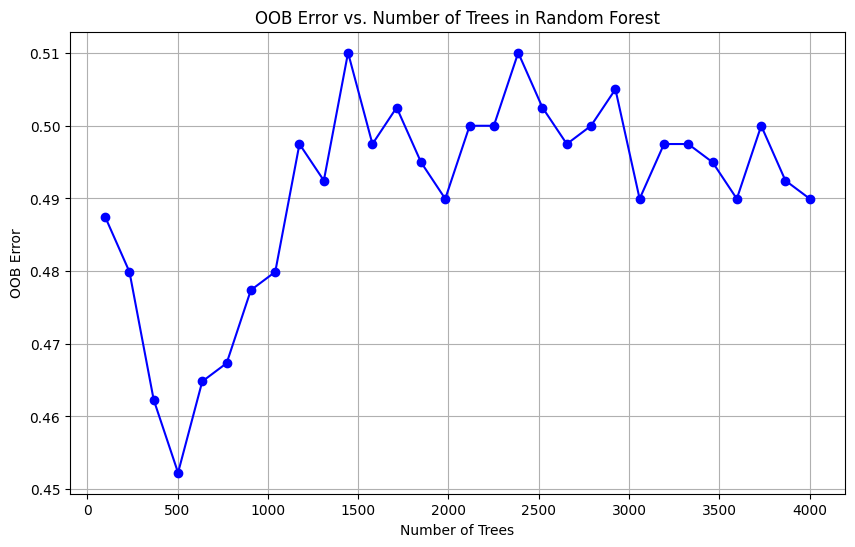

In [4]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 4000, num = 30)]
oob_errors = []

for n_trees in n_estimators:
    # create the RandomForestClassifier with the current number of trees
    forest = RandomForestClassifier(n_estimators=n_trees, 
                                    bootstrap=True,
                                    oob_score=True, 
                                    random_state=13)

    # fit the model on the training data
    forest.fit(X_train, y_train)

    # store the OOB error
    oob_error = 1 - forest.oob_score_
    oob_errors.append(oob_error)

# create a figure for the plot
plt.figure(figsize=(10, 6))
# plot the OOB errors against the number of trees used
plt.plot(n_estimators, oob_errors, marker='o', linestyle='-', color='b')
# set the title for the figure
plt.title('OOB Error vs. Number of Trees in Random Forest')
# provide axis labels
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
# enable grid for visual clarity
plt.grid(True)
# Save the plot to the Figures folder
plt.savefig('Figures/OOB_Error_vs_Number_of_Trees.png')
plt.show()

## Training and optimizing Random Forest classifiers
The code below performs a randomized gridsearch and tests 100 trees in 5-fold cross validation. Various hyperparameters were chosen to be optimized, most forcing the model to be more simple as previous tests have shown that overfitting is an issue with this model choice and dataset. Random gridsearch was employed because a systematic grid search would be computatianlly demanding and take a while. (there are 24,300 combinations of hyperparameters)

The below script runs for 11-12 minutes and the best model found by the random gridsearch is:
| Parameters | values |
| --- | --- |
| n_estimators | 1642 |
| max_features | sqrt |
| max_depth | 10 |
| min_samples_split | 10 |
| min_samples_leaf | 4 |
| max_samples | 0.4 |


In [5]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2500, num = 15)]
# number of features to consider for the best split
max_features = ['log2', 'sqrt']
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10] 
# minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# maximum number of samples taken for each bootstrap
max_samples = [float(x) for x in np.linspace(0.1, 0.9, num=9)]

# create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples' : max_samples}

# define the classifier to be used and optimized
forest = RandomForestClassifier(bootstrap = True, oob_score = True, n_jobs= -1, random_state= 13)
# define what score to be used to find the optimal solution
scorer = make_scorer(accuracy_score)
# perform random grid search, finding the best out of n_iter random combinations of paramters
opt = RandomizedSearchCV(forest, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs= -1, scoring= scorer, n_iter= 100, random_state=13).fit(X_train, y_train)
# print the best parameters to be used 
print(f"the best parameters are: {opt.best_params_}")
# save the optimal parameters
optimized_parameters = opt.best_params_
# save cross validation result to assess potential overfitting
cv_result = opt.cv_results_

the best parameters are: {'n_estimators': 1642, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.4, 'max_features': 'sqrt', 'max_depth': 10}


In [ ]:
# note down optimal parameters to not re-run optimization
optimized_parameters = {'n_estimators': 1642,
               'max_features': 'sqrt',
               'max_depth': 10,
               'min_samples_split': 10,
               'min_samples_leaf': 4,
               'max_samples' : 0.4}

## Validate the best classifier
With the optimized classifier obtained, it is tested with the independent test set to assess its performance on unseen data. Since differentiating between cancer and non-cancer is desired and the dataset is balanced, accuracy is used as an evaluation metric. Additionally the ROC curve and AUC is calculated to assess predictive performance and varying thresholds of labeling a sample as "cancer" and "non-cancer".

The train accuracy score is: 1.0
The test accuracy score is: 0.5491329479768786


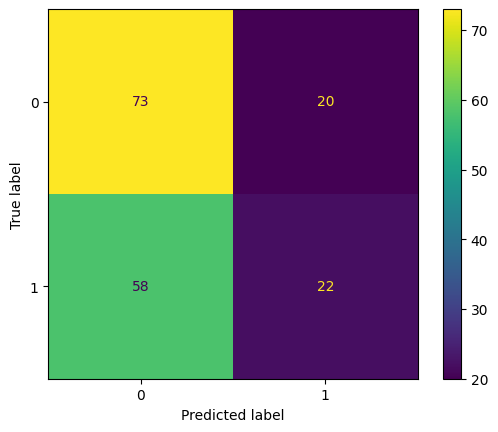

In [6]:
# supply the best parameters to the classifier
forest = RandomForestClassifier(**optimized_parameters, bootstrap = True, oob_score = True, random_state= 13)
# train the random forest
forest = forest.fit(X_train, y_train)
# predict the class (cancer yes:1 or no:0) of the test set
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)
# calculate performance metrics, accuracy is prioritized for this research aim
print(f"The train accuracy score is: {accuracy_score(y_train, y_pred_train)}") # train accuracy is assessed for overfitting
print(f"The test accuracy score is: {accuracy_score(y_test, y_pred)}")

# create a confusion matrix to visualize the resulting prediction
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
# Save the plot to the Figures folder
plt.savefig('Figures/confusion_all_features.png')
plt.show()

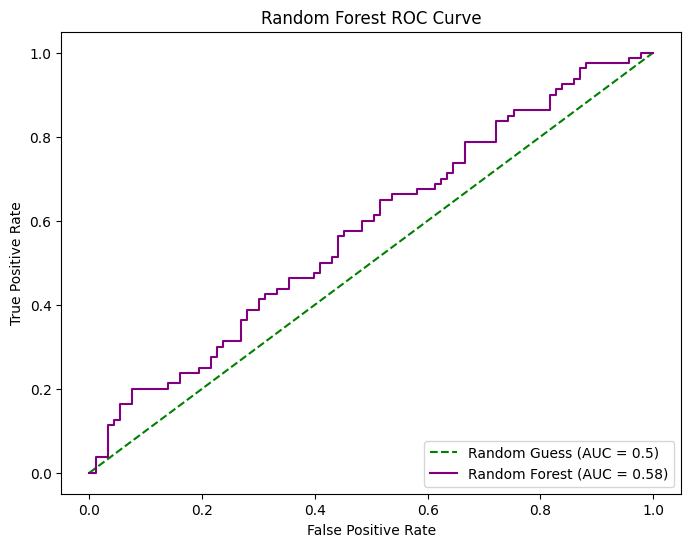

In [7]:
# extract the probabilities for the test set from the classifier
y_pred_probs = forest.predict_proba(X_test)[:,1]

# obtain the false positive (FPR) and true positive rates (TPR) for each threshold value
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
# calculate AUC
auc_value = roc_auc_score(y_test, y_pred_probs)

# plot the ROC curve
plt.figure(figsize=(8, 6))
# plot the dashed line representing a random guess baseline
plt.plot([0,1], [0,1], '--', label='Random Guess (AUC = 0.5)', color = 'green')
# plot the ROC curve
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_value:.2f})', color='purple')
# add labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
# add legend to show AUC
plt.legend(loc='lower right')
# save the plot to the Figures folder
plt.savefig('Figures/ROC_all_features.png')
plt.show()

## Assessing stability and feature importance
This code loops over all models and extracts the frequency at which a feature is used per CV fold. This can be used to assess model stability, how many times a feature was used and whether this number fluctuates a lot. Furthermore it can also select the most informative features to prevent redundancy and noisy features. From the heatmap it can be seen that most features are quite unstable and change importance per fold, only Hypoxanthine (feature 12) consistently scores higher than the other features. 

The code below runs for about 1-2 mins

In [8]:
best_forest = opt.best_estimator_
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)

# to store feature importance across each fold
feature_importances = np.zeros((10, X_train.shape[1]))

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train[train_idx], X_train[test_idx]
    y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]

    # fit the best estimator to the train data
    best_forest.fit(X_train_cv, y_train_cv)

    # extract the feature importances from the fitted forest
    fold_importances = best_forest.feature_importances_

    # accumulate feature importances for this fold
    feature_importances[fold_idx, :] = fold_importances

# sum feature importances across all folds to find the total importance per feature
total_feature_importance = np.mean(feature_importances, axis=0)
std_importances = np.std(feature_importances, axis=0)

# rank the features with most important first and least important last
feature_rank = np.argsort(total_feature_importance)[::-1]  # feature index
ranked_importance = total_feature_importance[feature_rank]  # mean feature importance
ranked_std = std_importances[feature_rank] # standard deviation of importance score
ranked_names = metabolite_names[feature_rank]  # feature name

# create an array storing all the information per feature
overview = np.column_stack((ranked_names, feature_rank, ranked_importance, ranked_std))


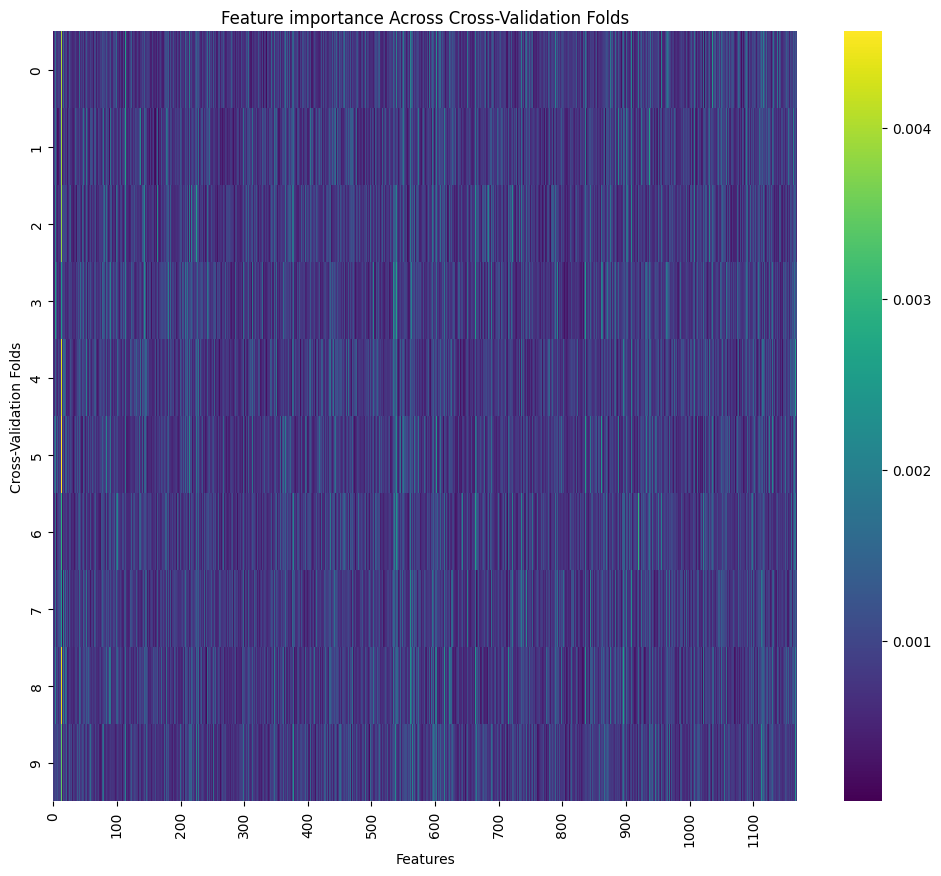

In [9]:
# create a new figure
plt.figure(figsize=(12, 10))
# plot a heatmap of all counts across each CV fold
sns.heatmap(feature_importances, cmap='viridis', annot=False, cbar=True)
# add a figure title
plt.title("Feature importance Across Cross-Validation Folds")
# add labels
plt.xlabel("Features")
plt.ylabel("Cross-Validation Folds")
# add ticks and labels to keep track which feature is shown on the x-axis
plt.xticks(ticks=np.arange(0, feature_importances.shape[1], 100), 
           labels=np.arange(0, feature_importances.shape[1], 100), rotation=90)
# Save the plot to the Figures folder
plt.savefig('Figures/Feature_importance_heatmap.png')
plt.show()

The code below tests which top highest feature cutoff performs the best on the current best classifier. This feature set is then used to train a new best classifier to reduce redundant and noisy features in the final prediction.

The code below runs for 1-2 mins.

In [10]:
oob_accuracies = []
proportions = np.linspace(start = 0.1, stop = 1, num = 10)

for x in proportions:
    num_features_to_select = int(np.floor(x * len(overview)))
    selected_idx = overview[:num_features_to_select, 1].astype(int).ravel()
    X_train_selected = X_train[:, selected_idx]
    X_test_selected = X_test[:, selected_idx]
    # supply the best parameters to the classifier directly
    forest = RandomForestClassifier(**optimized_parameters, bootstrap = True, oob_score = True, random_state= 13)
    # train the random forest
    forest = forest.fit(X_train_selected, y_train)
        # Record the OOB accuracy
    oob_accuracy = forest.oob_score_
    oob_accuracies.append(oob_accuracy)

# Find the proportion with the highest OOB accuracy
best_index = np.argmax(oob_accuracies)  # index of the highest OOB accuracy
best_proportion = proportions[best_index]  # corresponding proportion

print(f"The best proportion of features is: {best_proportion:.2f}")



The best proportion of features is: 0.10


## Training the random forest classifier on selected features
Now that the most important features were selected, the optimization can be done again with only using these features.

This runs for about 8-9 minutes

In [11]:
# select the best performing feature set 
num_features_to_select = int(np.floor(best_proportion * len(overview)))
selected_idx = overview[:num_features_to_select, 1].astype(int).ravel()
X_train_selected = X_train[:, selected_idx]
X_test_selected = X_test[:, selected_idx]

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2500, num = 15)]
# number of features to consider for the best split
max_features = ['log2', 'sqrt']
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10] 
# minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# maximum number of samples taken for each bootstrap
max_samples = [float(x) for x in np.linspace(0.1, 0.9, num=9)]

# create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples' : max_samples}

# define the classifier to be used and optimized
forest = RandomForestClassifier(bootstrap = True, oob_score = True, n_jobs= -1, random_state= 13)
# define what score to be used to find the optimal solution
scorer = make_scorer(accuracy_score)
# perform random grid search, finding the best out of 50 random combinations of paramters
opt = RandomizedSearchCV(forest, param_grid, cv=5, n_jobs= -1, scoring= scorer, n_iter= 100, random_state=13).fit(X_train_selected, y_train)
# print the best parameters to be used when re-running parts of the code at another time
print(f"the best parameters are: {opt.best_params_}")
optimized_parameters = opt.best_params_

the best parameters are: {'n_estimators': 2500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.7000000000000001, 'max_features': 'log2', 'max_depth': 20}


In [ ]:
# note down optimal parameters to not re-run optimization
optimized_parameters = {'n_estimators': 2500,
               'max_features': 'log2',
               'max_depth': 20,
               'min_samples_split': 2,
               'min_samples_leaf': 2,
               'max_samples' : 0.7}

The train accuracy score is: 1.0
The accuracy score is: 0.5491329479768786


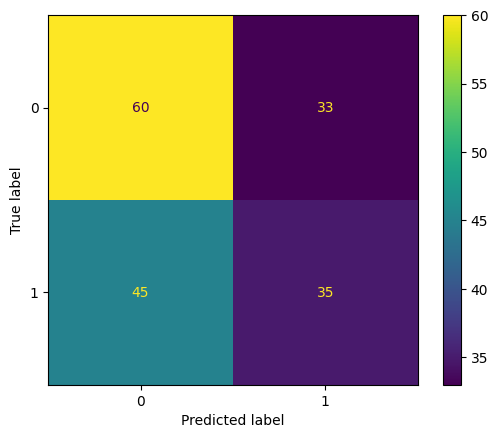

In [14]:
# supply the best parameters to the classifier directly
forest = RandomForestClassifier(**optimized_parameters, bootstrap = True, oob_score = True, random_state= 13)
# train the random forest
forest = forest.fit(X_train_selected, y_train)
# predict the class (cancer yes:1 or no:0) of the test set
y_pred_train = forest.predict(X_train_selected)
y_pred = forest.predict(X_test_selected)
# calculate performance metrics, accuracy is prioritized for this research aim
print(f"The train accuracy score is: {accuracy_score(y_train, y_pred_train)}") # train accuracy is assessed for overfitting
print(f"The accuracy score is: {accuracy_score(y_test, y_pred)}")


# create a confusion matrix to visualize the resulting prediction
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
# save the plot to the Figures folder
plt.savefig('Figures/confusion_selected_features.png')
plt.show()

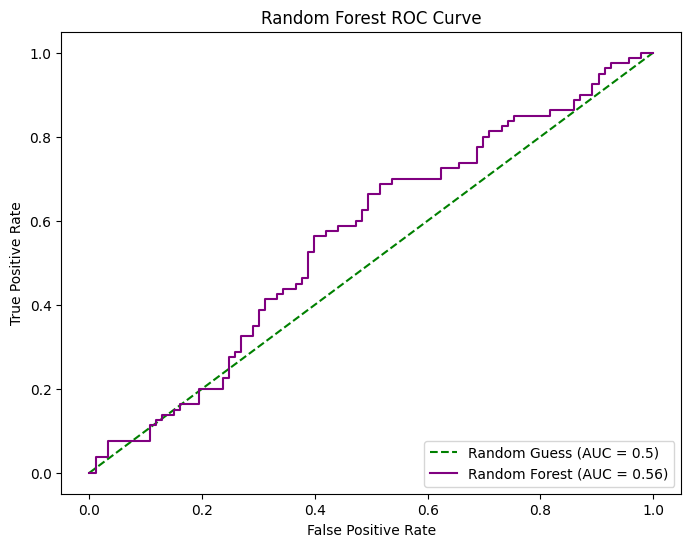

In [15]:
# extract the probabilities for the test set from the classifier
y_pred_probs = forest.predict_proba(X_test_selected)[:,1]

# obtain the false positive (FPR) and true positive rates (TPR) for each threshold value
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
# Calculate AUC
auc_value = roc_auc_score(y_test, y_pred_probs)

# plot the ROC curve
plt.figure(figsize=(8, 6))
# plot the dashed line representing a random guess baseline
plt.plot([0,1], [0,1], '--', label='Random Guess (AUC = 0.5)', color = 'green')
# plot the ROC curve
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_value:.2f})', color='purple')
# add labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
# add legend to show AUC
plt.legend(loc='lower right')
# save the plot to the Figures folder
plt.savefig('Figures/ROC_selected_features.png')
plt.show()